In [89]:
import numpy as np
import pandas as pd
import glob
import torch
import pickle
import os
import glob, sys
import matplotlib.pyplot as plt
import matplotlib
from matplotlib.font_manager import _rebuild; _rebuild()
%matplotlib inline 
import seaborn as sns
from matplotlib.lines import Line2D

os.environ['KMP_DUPLICATE_LIB_OK']='True'
sys.path.append(os.path.join(os.path.abspath(os.getcwd()),".."))
parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))

# plt.style.use('seaborn-whitegrid')
plt.rcParams.update({'lines.markeredgewidth': 1})
%matplotlib inline 
import seaborn as sns
from matplotlib.lines import Line2D
matplotlib.rcParams['text.usetex'] = True
matplotlib.rc('font',family='serif', serif=['Palatino'])
# sns.set_style('white')

pgf_with_rc_fonts = {"pgf.texsystem": "pdflatex"}
matplotlib.rcParams.update(pgf_with_rc_fonts)

# import FERL Modules
from utils.learned_feature import LearnedFeature
from utils.plot_utils import *
from utils.environment_utils import *

In [2]:
# Analyze quantitative data (table, laptop, proxemics) & Plot that -> Marius
# MSE for GT-expert: data/user_data/0_{feature}.p 
# MSE for GT-user
# MSE for GT-random

In [71]:
features = ['laptop', 'table', 'proxemics']
n_rand = 5

In [78]:
rand_MSEs_to_plot = []
expert_MSEs_to_plot = []
user_MSEs_to_plot = []

for feat in features:
    # Step 1: load GT and User learned feature functions
    data_file = parent_dir + '/data/gtdata/data_{}.npz'.format(feat)
    npzfile = np.load(data_file)
    train = npzfile['x']
    gt_labels = npzfile['y'].reshape(-1,1)
    gt_labels = (gt_labels - gt_labels.min())/(gt_labels.max() - gt_labels.min())

    # load expert learned_function
    all_expert_feat_files = glob.glob(parent_dir + '/data/expert_data/expert?_{}_1.pt'.format(feat)) + \
                    glob.glob(parent_dir + '/data/expert_data/expert??_{}_1.pt'.format(feat))
    list_of_learned_expert_features = []
    n_experts = len(all_expert_feat_files)
    for expert_feat_file in all_expert_feat_files:
        list_of_learned_expert_features.append(torch.load(expert_feat_file))

    # user learned feature_functions
    all_user_feat_files = glob.glob(parent_dir + '/data/user_data/user?_{}_1.pt'.format(feat)) + \
                        glob.glob(parent_dir + '/data/user_data/user??_{}_1.pt'.format(feat))
    list_of_learned_user_features = []
    n_users = len(all_user_feat_files)
    for user_feat_file in all_user_feat_files:
        list_of_learned_user_features.append(torch.load(user_feat_file))
        
    # Step 2: calculate random, user & expert MSE

    ## random MSE
    LF_dict = {'bet_data':5, 'sin':False, 'cos':False, 'rpy':False, 'lowdim':False, 'norot':True,
           'noangles':True, '6D_laptop':False, '6D_human':False, '9D_coffee':False, 'EErot':False,
           'noxyz':False, 'subspace_heuristic':False}
    rand_MSE = []
    for j in range(n_rand):
        rand_feature = LearnedFeature(2, 64, LF_dict)
        rand_labels = rand_feature.function(train)
        # normalize output to [0,1](because internal normalization is not working without data)
        norm_rand_labels = (rand_labels - rand_labels.min())/(rand_labels.max() - rand_labels.min())
        rand_MSE.append(((gt_labels - norm_rand_labels)**2).mean())


    ## expert MSE
    expert_MSEs = []
    for i in range(n_experts):
        learned_label = list_of_learned_expert_features[i].function(train)
        mse_temp = ((gt_labels - learned_label)**2).mean()
        expert_MSEs.append(mse_temp)

    ## Users MSEs
    user_MSEs = []
    for i in range(n_users):
        learned_label = list_of_learned_user_features[i].function(train)
        mse_temp = ((gt_labels - learned_label)**2).mean()
        user_MSEs.append(mse_temp)
        
    # Step 3: sort in in overall lists
    rand_MSEs_to_plot.append(rand_MSE)
    expert_MSEs_to_plot.append(expert_MSEs)
    user_MSEs_to_plot.append(user_MSEs)

In [79]:
print(expert_MSEs_to_plot[1])
print(all_expert_feat_files[3])

[0.005145162700893985, 0.005810789280993085, 0.004371217433211492, 0.002707131605225949, 0.005571578328546572, 0.007036309723407253, 0.002036841781105589, 0.005615785418228198, 0.008233392928465488, 0.009107806482315337, 0.0030444736612195386, 0.002853197994915737]
/Volumes/Data/2_Work/2_Graduate_Research/03_Tomlin/5_HRI_Feature_Learning/FERL_sim/data/expert_data/expert2_proxemics_1.pt


In [80]:
print([np.mean(x) for x in user_MSEs_to_plot])
print(expert_MSEs_to_plot)

[0.03602367590495741, 0.028496050342372372, 0.048581767053016756]
[[0.01083534293679631, 0.015604318558502351, 0.03907977803886182, 0.009061723120894975, 0.06475295286553248, 0.01516372369518344, 0.010675644657455657, 0.008615253929633858, 0.008882587633542691, 0.004691318884111251, 0.02278097082463513, 0.03423407454774191], [0.005145162700893985, 0.005810789280993085, 0.004371217433211492, 0.002707131605225949, 0.005571578328546572, 0.007036309723407253, 0.002036841781105589, 0.005615785418228198, 0.008233392928465488, 0.009107806482315337, 0.0030444736612195386, 0.002853197994915737], [0.020043625061946912, 0.020225983349155045, 0.01919780779861719, 0.016409554622285213, 0.017521789462570637, 0.0114128982770782, 0.01489427124024152, 0.033090595764815094, 0.0192527035700475, 0.011477232917742178, 0.01669746703672578, 0.013419327710534657]]


# Plot Comparison

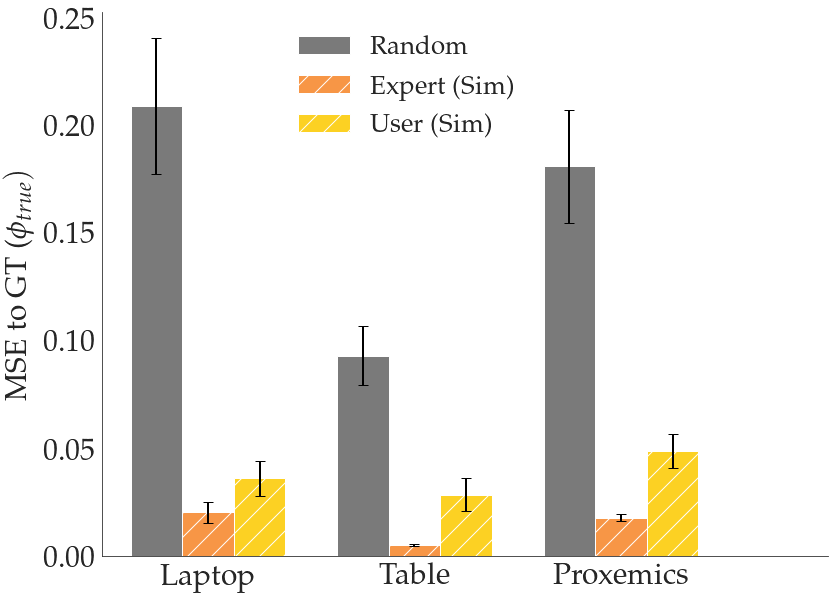

In [109]:
bar_plot(rand_MSEs_to_plot, expert_MSEs_to_plot, user_MSEs_to_plot)

In [82]:
# add random
# different shade of gray

In [38]:
to_plot = list_of_learned_features[4]

In [39]:
# plot_gt3D(parent_dir, feat)

In [93]:
# plot_learned3D(parent_dir, to_plot.function, feat=feat)

In [108]:
def bar_plot(GT, MEIRL, FERL):
    fontsize = 30
    # Plot the pstar
    fig = plt.figure(figsize=(13,10))
    matplotlib.rcParams.update({'font.size': fontsize})
    plt.rcParams['xtick.labelsize']=fontsize
    plt.rcParams['ytick.labelsize']=fontsize

    
#     set_style()
    FERL_color = '#fcd123'  # User
    MEIRL_color = '#f79646' # Expert
    GT_color = '#7a7a7a' # Random
    labels = ["Random", "Expert (Sim)", "User (Sim)"]

    # set width of bar
    barWidth = 0.25

    for i in range(len(GT)):
        # Process input costs.
        gt_rel = np.array(GT[i])
        learned_rel = np.array(MEIRL[i])
        our_rel = np.array(FERL[i])

        # set height of bar
        bars1_mean = np.mean(gt_rel)
        bars1_sem = np.std(gt_rel) / np.sqrt(len(GT[i]))
        bars2_mean = np.mean(learned_rel)
        bars2_sem = np.std(learned_rel) / np.sqrt(len(MEIRL[i]))
        bars3_mean = np.mean(our_rel)
        bars3_sem = np.std(our_rel) / np.sqrt(len(FERL[i]))
    
        # Set position of bar on X axis
        r1 = np.arange(i, i+1)
        r2 = [x + barWidth for x in r1]
        r3 = [x + 2*barWidth for x in r1]

        # Make the plot
        if i > 0:
            labels = [None]*len(GT)
        plt.bar(r1, bars1_mean, yerr=bars1_sem, color=GT_color, width=barWidth,
                ecolor='black', error_kw=dict(elinewidth=2, capsize=5), label=labels[0])
        plt.bar(r2, bars2_mean, yerr=bars2_sem, color=MEIRL_color, width=barWidth,
                ecolor='black', error_kw=dict(elinewidth=2, capsize=5), label=labels[1], hatch='/')
        plt.bar(r3, bars3_mean, yerr=bars3_sem, color=FERL_color, width=barWidth,
                ecolor='black', error_kw=dict(elinewidth=2, capsize=5), label=labels[2], hatch='/')
    #axs.plot([0,n_max],[1, 1],color=random_color, linestyle='dashed', linewidth=6)
    # Add xticks on the middle of the group bars
    #plt.xlabel('Experimental Case', fontsize=fontsize)
    plt.ylabel('MSE to GT ($\phi_{true})$', fontsize=fontsize)
    #plt.title("Induced Reward Relative to Ground Truth", fontsize=fontsize)
    plt.setp(plt.xticks()[1], fontsize=fontsize)
    plt.setp(plt.yticks()[1], fontsize=fontsize)
    plt.xticks(np.arange(4)+barWidth, ["Laptop","Table","Proxemics"])
    
    # Create legend & Show graphic
    plt.legend(fontsize=26, frameon=False,loc=1,bbox_to_anchor=(0.6, 1.0))#, mode="expand", ncol=3)
    sns.despine(fig)
    plt.savefig(parent_dir + '/data/images/UserStudy_Feature_MSE.pdf')
    plt.show()

# Train expert functions with traces

In [13]:
# # train expert functions with traces
# features = ['human', 'laptop', 'proxemics', 'table']

# for feat in features:
#     # Step 1: load traces
#     traces_file = parent_dir + '/data/expert_data/expert_{}.p'.format(feat)
#     with open(traces_file, 'rb') as f:
#         traces = pickle.load(f)

#     # Step 2: train feature
#     LF_dict = {'bet_data':5, 'sin':False, 'cos':False, 'rpy':False, 'lowdim':False, 'norot':True,
#            'noangles':True, '6D_laptop':False, '6D_human':False, '9D_coffee':False, 'EErot':False,
#            'noxyz':False, 'subspace_heuristic':False}
#     unknown_feature = LearnedFeature(2, 64, LF_dict)

#     all_trace_data = np.empty((0, 97), float)
#     for idx in range(len(traces)):
#         trace = traces[idx]
#         unknown_feature.add_data(trace)

#     _ = unknown_feature.train(epochs=100, batch_size=32, learning_rate=1e-3, weight_decay=0.001, s_g_weight=10.)
    
#     filename = parent_dir + '/data/expert_data/expert_{}.pt'.format(feat)
#     torch.save(unknown_feature, filename)